# 폐렴 진단하기

## Step 1. 실험환경 Set-up

In [1]:
import re
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# BATCH_SIZE 변수
BATCH_SIZE = 16

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# EPOCH 크기 변수
EPOCHS = 25

## Step 2. 데이터 준비하기

In [3]:
# data load
train_filenames = tf.io.gfile.glob('./train/*/*')
test_filenames = tf.io.gfile.glob('./test/*/*')
val_filenames = tf.io.gfile.glob('./val/*/*')

print(len(train_filenames)) # 5216
print(len(test_filenames))  # 624
print(len(val_filenames))   # 16

5216
624
16


In [4]:
# train, val dataset 분리
filenames = tf.io.gfile.glob('./train/*/*')
filenames.extend(tf.io.gfile.glob('./val/*/*'))

# train, test(val) dataset으로 분할. test_size에 0.2는 20%롤 의미함.
train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

print(len(train_filenames)) # 4185
print(len(val_filenames))   # 1047

# 정상/폐렴 이미지 수 확인
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL)) # 1076

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA)) # 3109

4185
1047
Normal images count in training set: 1065
Pneumonia images count in training set: 3120


In [5]:
# tf.data 인스턴스 생성
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

# train, val dataset 갯수 확인
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT)) # 4185

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT)) # 1047

# label 이름 확인
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob("./train/*")])
print(CLASS_NAMES) # ['PNEUMONIA' 'NORMAL']

Training images count: 4185
Validating images count: 1047
['PNEUMONIA' 'NORMAL']


In [6]:
# label data 생성
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)를 리턴하게 합니다.

In [7]:
# 이미지 데이터 타입 float로 변경 후 resize
def decode_img(img):
  # 이미지를 uint8 tensor로 바꾼다.
  img = tf.image.decode_jpeg(img, channels=3)
  # img를 범위 [0,1]의 float32 데이터 타입으로 바꾼다.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
  return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [8]:
# train, val dataset 생성
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

# 이미지 확인
for image, label in train_ds.take(1): # take(1) 하나의 데이터만 가져오기
    print("Image shape: ", image.numpy().shape) # (180, 180, 3)
    print("Label: ", label.numpy()) # True

# testset 생성
test_list_ds = tf.data.Dataset.list_files('./test/*/*')
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT) # 624

Image shape:  (180, 180, 3)
Label:  False
624


In [29]:
# tf.data 파이프라인 사용
def prepare_for_training(ds, shuffle_buffer_size=1000):

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## Step 3. 데이터 시각화

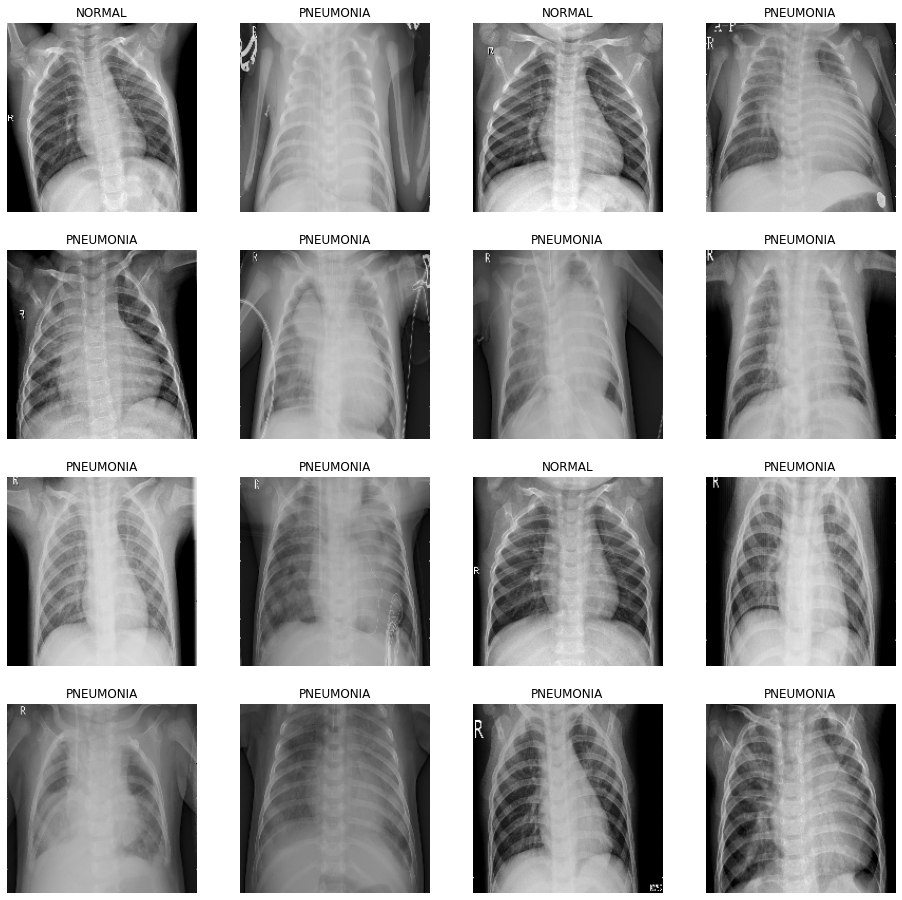

In [31]:
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(16,16))
    for n in range(16):
        ax = plt.subplot(4,4,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

## Step 4. CNN 모델링

In [11]:
# Conv Layer
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

In [12]:
# Dense Layer
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [13]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## Step 5. 데이터 imbalance 처리

In [14]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0)) # 1.94
print('Weight for class 1: {:.2f}'.format(weight_for_1)) # 0.67

Weight for class 0: 1.96
Weight for class 1: 0.67


## Step 6. 모델 훈련

In [36]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 26s 101ms/step - loss: 0.3686 - accuracy: 0.8197 - precision: 0.9587 - recall: 0.7919 - val_loss: 0.6265 - val_accuracy: 0.7317 - val_precision: 0.7317 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 23s 87ms/step - loss: 0.2325 - accuracy: 0.9083 - precision: 0.9746 - recall: 0.9003 - val_loss: 0.9830 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 23s 88ms/step - loss: 0.1901 - accuracy: 0.9246 - precision: 0.9791 - recall: 0.9183 - val_loss: 0.2173 - val_accuracy: 0.9067 - val_precision: 0.8879 - val_recall: 0.9987
Epoch 4/25
261/261 [==============================] - 23s 87ms/step - loss: 0.1577 - accuracy: 0.9392 - precision: 0.9815 - recall: 0.9360 - val_loss: 0.1139 - val_accuracy: 0.9567 - val_precision: 0.9569 - val_recall: 0.9856
Epoch 5/25
261/261 [==============================] - 22s 85ms/step - loss: 0.1518 - accuracy: 

## Step 7. 결과 확인과 시각화

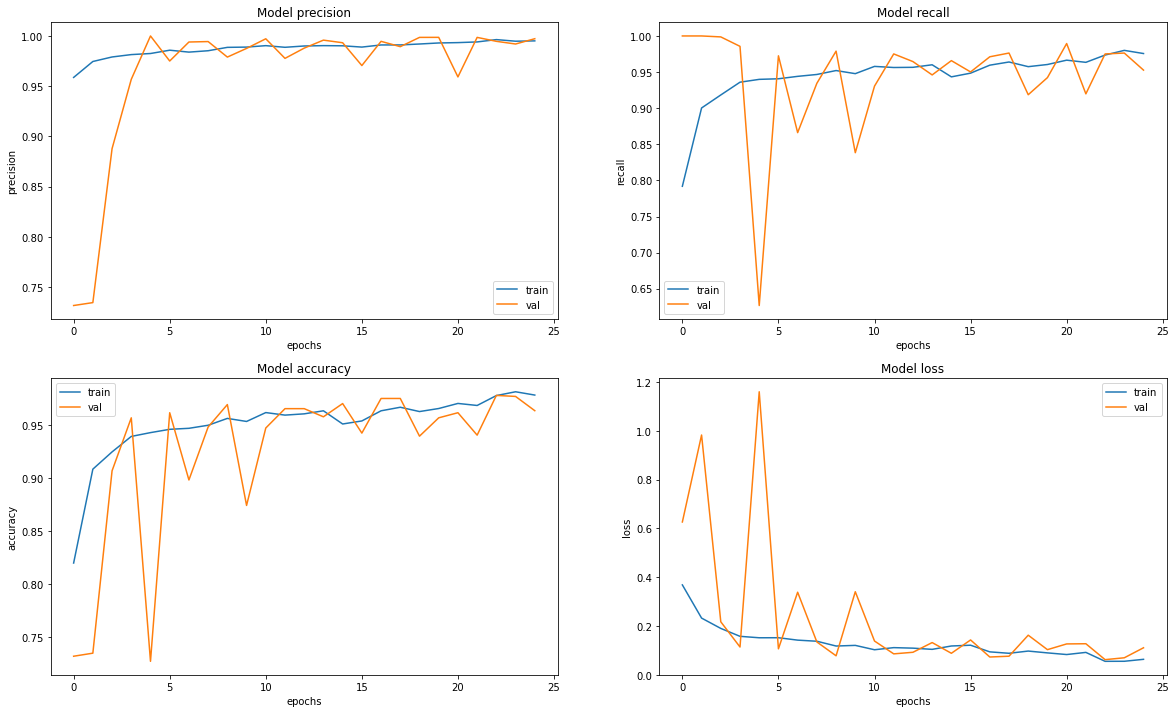

In [50]:
fig, ax = plt.subplots(2, 2, figsize=(20, 12))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [51]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 2s 62ms/step - loss: 0.6635 - accuracy: 0.8622 - precision: 0.8378 - recall: 0.9667


## Augmentation기법 사용

In [9]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

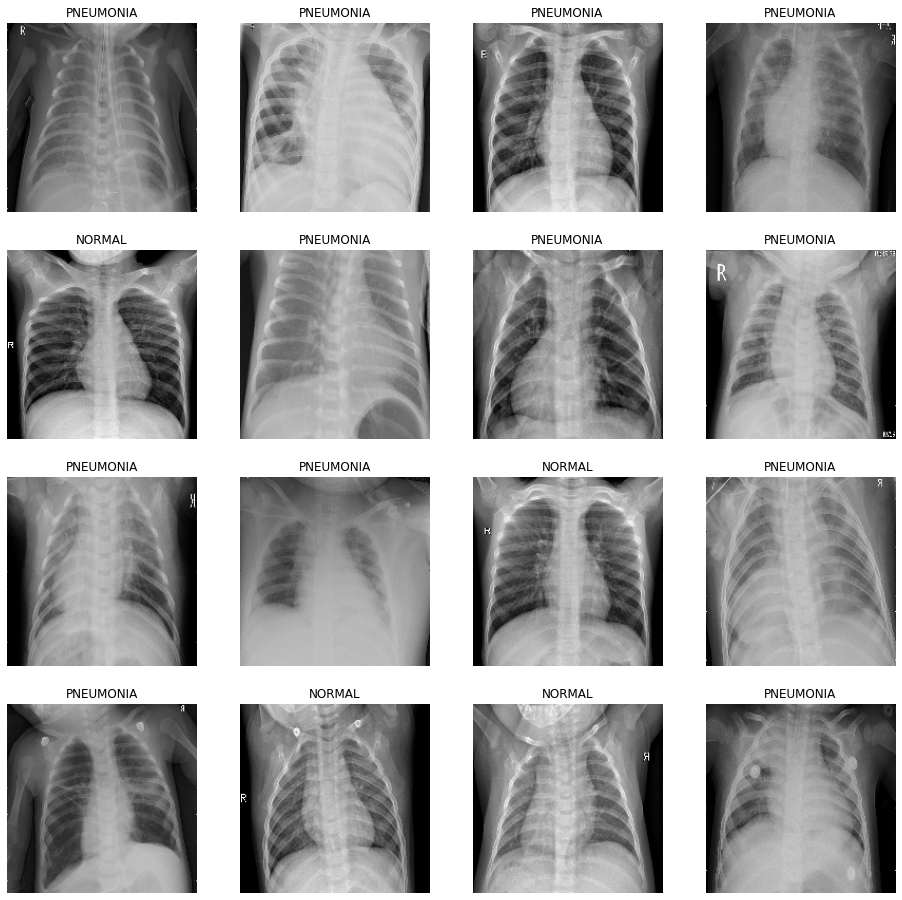

In [10]:
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(16,16))
    for n in range(16):
        ax = plt.subplot(4,4,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

In [15]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [16]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 27s 104ms/step - loss: 0.4182 - accuracy: 0.8020 - precision: 0.9486 - recall: 0.7765 - val_loss: 0.7428 - val_accuracy: 0.7279 - val_precision: 0.7279 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 24s 91ms/step - loss: 0.2597 - accuracy: 0.8958 - precision: 0.9708 - recall: 0.8870 - val_loss: 1.4279 - val_accuracy: 0.7279 - val_precision: 0.7279 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 23s 88ms/step - loss: 0.2159 - accuracy: 0.9121 - precision: 0.9731 - recall: 0.9071 - val_loss: 0.9786 - val_accuracy: 0.7279 - val_precision: 0.7279 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 23s 88ms/step - loss: 0.1873 - accuracy: 0.9236 - precision: 0.9768 - recall: 0.9194 - val_loss: 0.0948 - val_accuracy: 0.9663 - val_precision: 0.9826 - val_recall: 0.9710
Epoch 5/25
261/261 [==============================] - 23s 87ms/step - loss: 0.2075 - accuracy: 

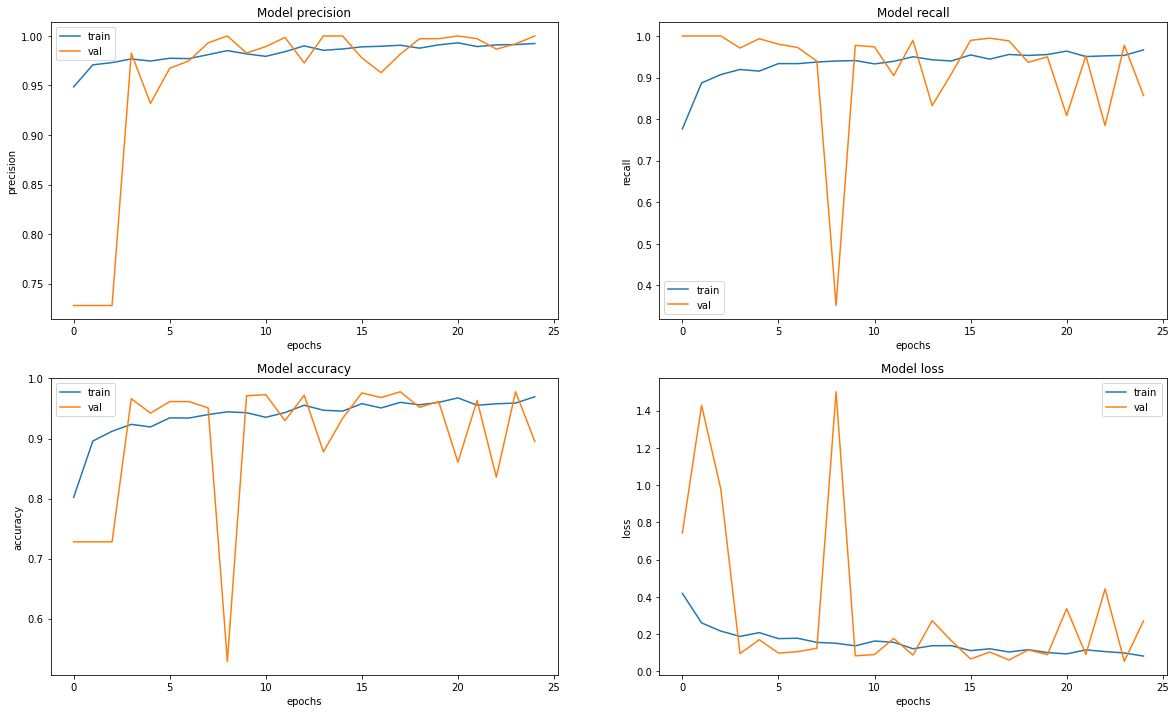

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(20, 12))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [18]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 2s 61ms/step - loss: 0.4961 - accuracy: 0.8638 - precision: 0.8640 - recall: 0.9282


## 회고록

- 의료분야는 인공지능을 활용해보고 싶은 분야중 하나였기 때문에 오늘 의료데이터를 이용한 실습을 하게되어 좋은 경험이었다.
- 노드에서 학습한 내용만으로도 이미 충분히 높은 정확도를 보여주었기 때문에 별 다른 Tuning을 하지 않아도 Lubric을 만족하였다. 그러나 정확도를 더 높여보고자 여러가지 방법을 시도해보았다.
- 이미지의 해상도가 높아지면 정확도가 올라갈 것이라고 예상하여 360x360, 480x480으로 시도해보았으나 오히려 정확도가 더 낮게 나왔다. Convolution Layer의 filter의 크기가 적절하지 않았을 가능성도 있어서 filter 크기를 변경하여 다시 시도해봐야겠다.
- Dropout을 감소시켰더니 오히려 정확도가 감소하였다. train set에 Overfitting 된 것 같다.
- 이미지의 해상도를 높였을 때 filter 갯수를 늘려서 parameter를 거의 2배 이상 늘렸음에도 불구하고 정확도는 크게 차이가 없었다. parameter를 더 늘려봐야 하는 걸까...